In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

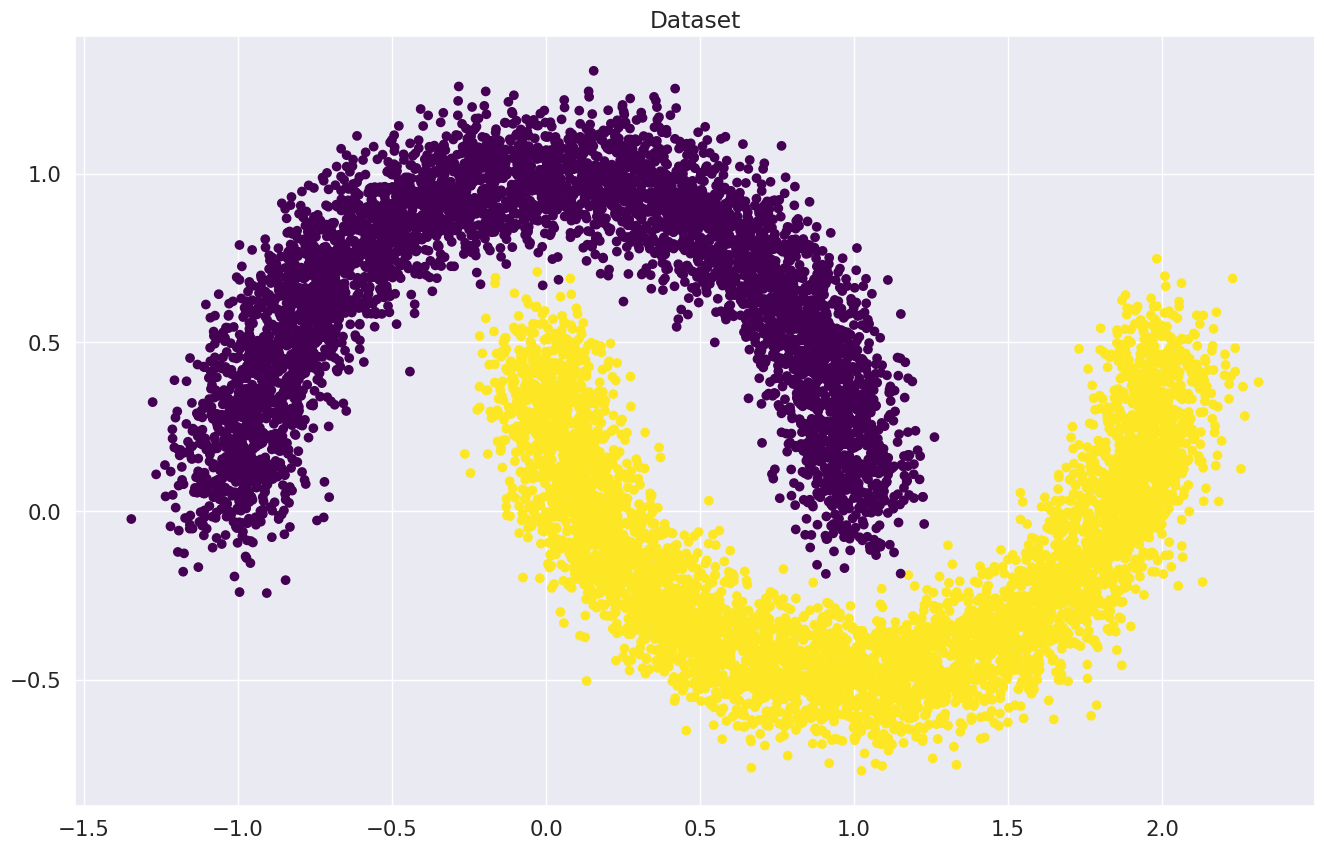

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [5]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
y_val_t =  torch.FloatTensor(y_val)
X_val_t =  torch.FloatTensor(X_val)

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features), requires_grad=True)

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
!pip install torchinfo

In [9]:
from torchinfo import summary
summary(linear_regression, (1, 2), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

Кол - во параметров у обучаемой модели: 3

### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp.view(-1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.265625
Iteration: 100
Batch accuracy: 0.875
Iteration: 200
Batch accuracy: 0.8359375
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 759


### Визуализируем результаты

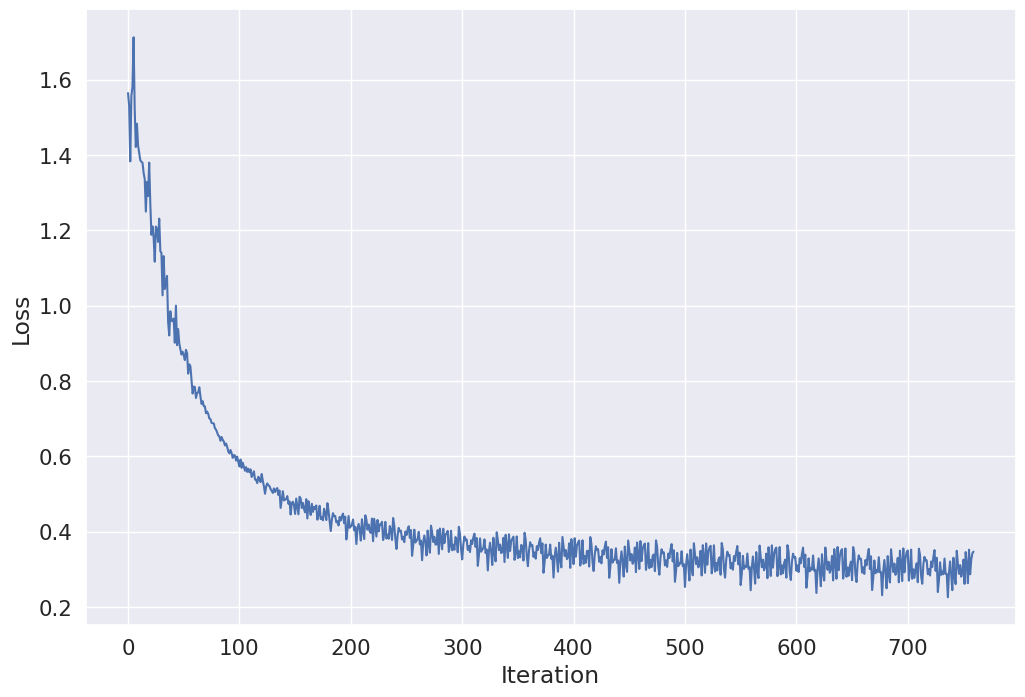

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

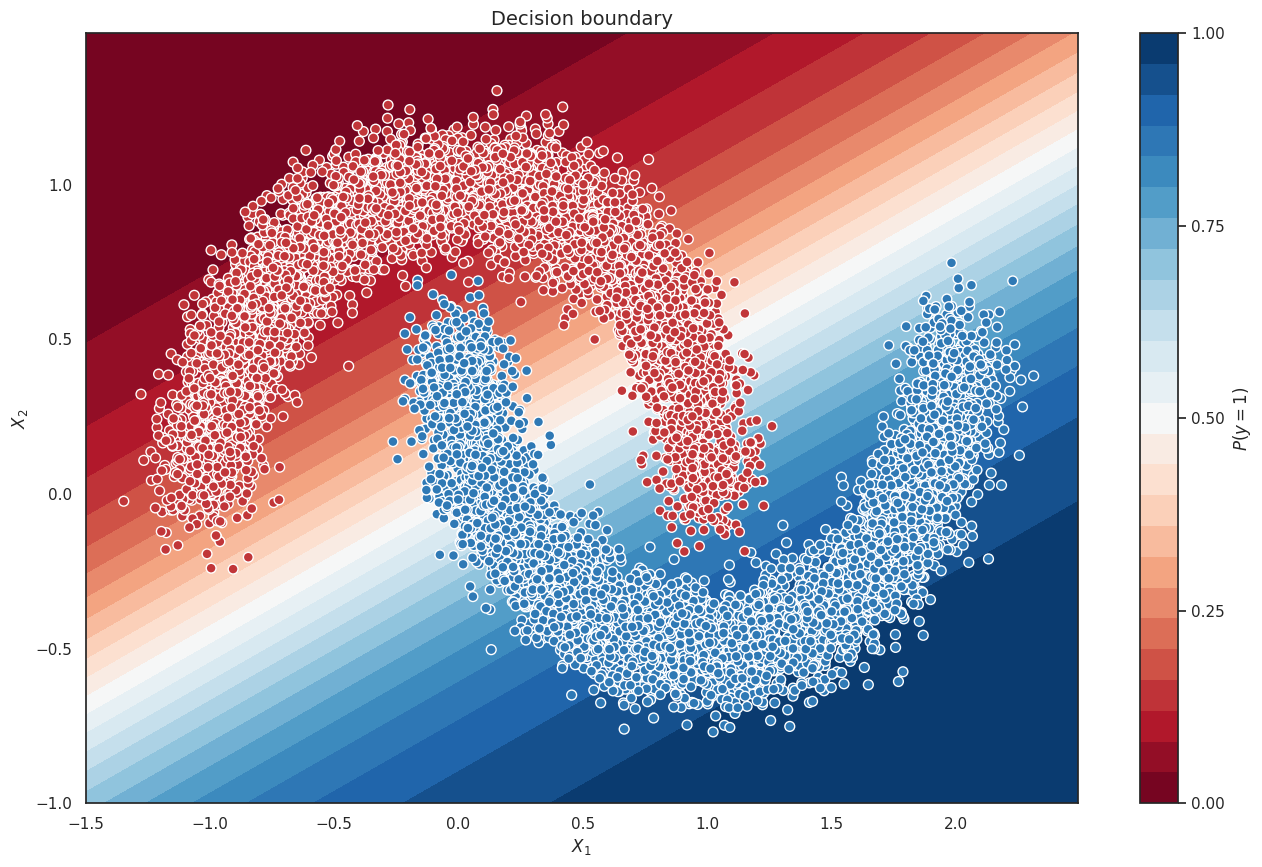

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = torch.sigmoid(model(x_batch))
        preds = (outp > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [14]:

from sklearn.metrics import accuracy_score

preds = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t, preds)

0.866

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.866

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [15]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 79552621.02it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80222313.79it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19164442.13it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5236538.97it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

model = model.to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [27]:
max_epochs = 10
accuracy = {"train": [], "valid": []}


for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if (k == "train"):
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = torch.softmax(model(x_batch), dim=1)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.895
Loader: valid. Accuracy: 0.9348
Epoch: 2
Loader: train. Accuracy: 0.9529166666666666
Loader: valid. Accuracy: 0.961
Epoch: 3
Loader: train. Accuracy: 0.9662833333333334
Loader: valid. Accuracy: 0.9639
Epoch: 4
Loader: train. Accuracy: 0.97215
Loader: valid. Accuracy: 0.9747
Epoch: 5
Loader: train. Accuracy: 0.97665
Loader: valid. Accuracy: 0.9668
Epoch: 6
Loader: train. Accuracy: 0.9796666666666667
Loader: valid. Accuracy: 0.9723
Epoch: 7
Loader: train. Accuracy: 0.9815666666666667
Loader: valid. Accuracy: 0.9743
Epoch: 8
Loader: train. Accuracy: 0.985
Loader: valid. Accuracy: 0.9698
Epoch: 9
Loader: train. Accuracy: 0.9848666666666667
Loader: valid. Accuracy: 0.9746
Epoch: 10
Loader: train. Accuracy: 0.98725
Loader: valid. Accuracy: 0.9758


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [29]:
elu_accuracy = accuracy["valid"]

In [30]:
def test_activation_function(activation):
  model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
  )

  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  loaders = {"train": train_dataloader, "valid": valid_dataloader}

  max_epochs = 10
  accuracy = {"train": [], "valid": []}

  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              x_batch, y_batch = x_batch.to(device), y_batch.to(device)
              if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
              else:
                model.eval()
                with torch.no_grad():
                  outp = torch.softmax(model(x_batch), dim=1)
              preds = outp.argmax(-1)
              correct = (preds == y_batch).sum()
              all = len(preds)
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()

          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)

  return accuracy["valid"]

In [31]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8766333333333334
Loader: valid. Accuracy: 0.9056
Epoch: 2
Loader: train. Accuracy: 0.90305
Loader: valid. Accuracy: 0.9141
Epoch: 3
Loader: train. Accuracy: 0.9063166666666667
Loader: valid. Accuracy: 0.9095
Epoch: 4
Loader: train. Accuracy: 0.90815
Loader: valid. Accuracy: 0.9141
Epoch: 5
Loader: train. Accuracy: 0.9095833333333333
Loader: valid. Accuracy: 0.911
Epoch: 6
Loader: train. Accuracy: 0.9124166666666667
Loader: valid. Accuracy: 0.9142
Epoch: 7
Loader: train. Accuracy: 0.9128333333333334
Loader: valid. Accuracy: 0.9091
Epoch: 8
Loader: train. Accuracy: 0.9131833333333333
Loader: valid. Accuracy: 0.9182
Epoch: 9
Loader: train. Accuracy: 0.91605
Loader: valid. Accuracy: 0.9036
Epoch: 10
Loader: train. Accuracy: 0.9142333333333333
Loader: valid. Accuracy: 0.9166
Epoch: 1
Loader: train. Accuracy: 0.8795166666666666
Loader: valid. Accuracy: 0.9313
Epoch: 2
Loader: train. Accuracy: 0.9421666666666667
Loader: valid. Accuracy: 0.9563
Epoch: 3
Load

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

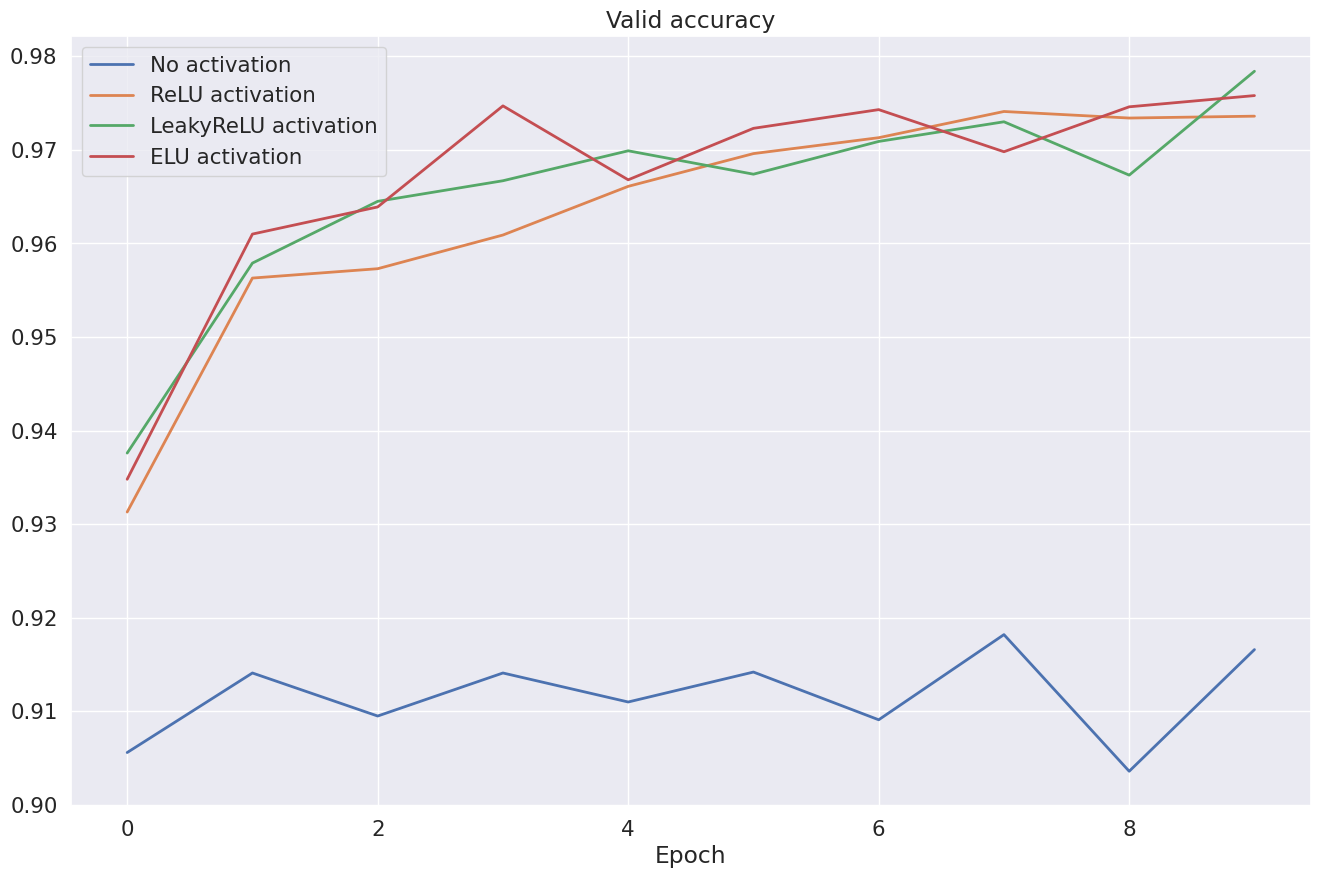

In [32]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

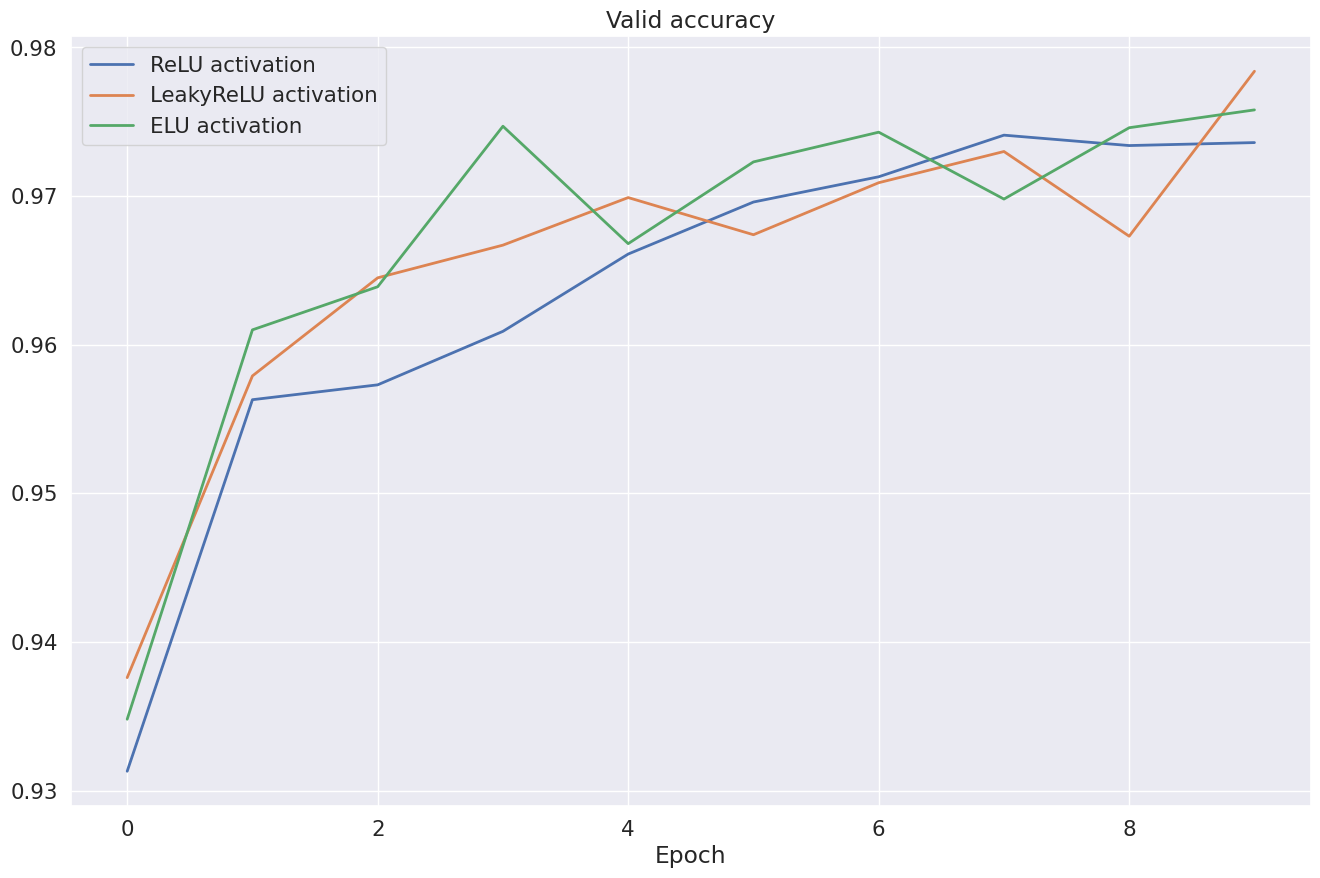

In [33]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [34]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-06 20:20:39--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   180KB/s    in 0.3s    

2023-11-06 20:20:40 (180 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



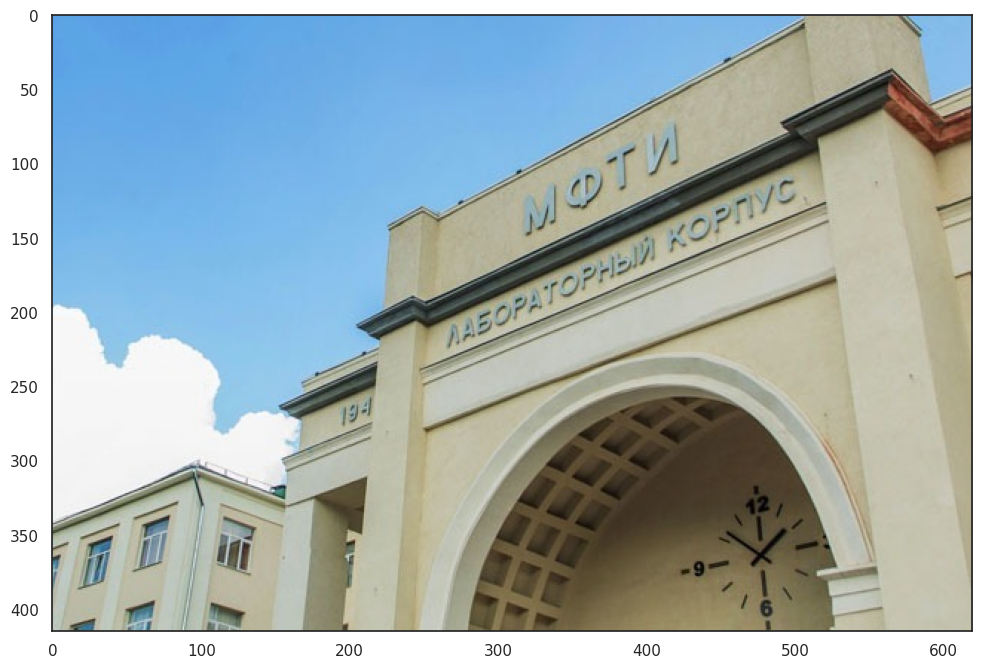

In [35]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [36]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

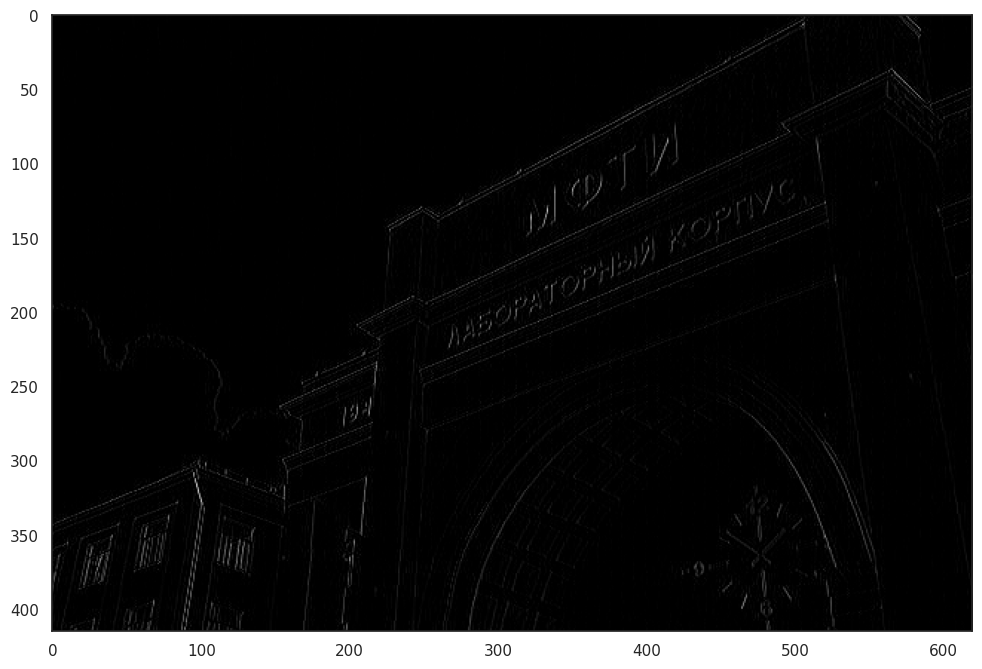

In [37]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [38]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [40]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8979833333333334
Loader: valid. Accuracy: 0.9633
Epoch: 2
Loader: train. Accuracy: 0.9704666666666667
Loader: valid. Accuracy: 0.9801
Epoch: 3
Loader: train. Accuracy: 0.9782
Loader: valid. Accuracy: 0.9838
Epoch: 4
Loader: train. Accuracy: 0.9831
Loader: valid. Accuracy: 0.9822
Epoch: 5
Loader: train. Accuracy: 0.9858333333333333
Loader: valid. Accuracy: 0.9862
Epoch: 6
Loader: train. Accuracy: 0.9881833333333333
Loader: valid. Accuracy: 0.9863
Epoch: 7
Loader: train. Accuracy: 0.9894
Loader: valid. Accuracy: 0.9846
Epoch: 8
Loader: train. Accuracy: 0.9913
Loader: valid. Accuracy: 0.9859
Epoch: 9
Loader: train. Accuracy: 0.9921166666666666
Loader: valid. Accuracy: 0.9823
Epoch: 10
Loader: train. Accuracy: 0.9936333333333334
Loader: valid. Accuracy: 0.9875


In [41]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

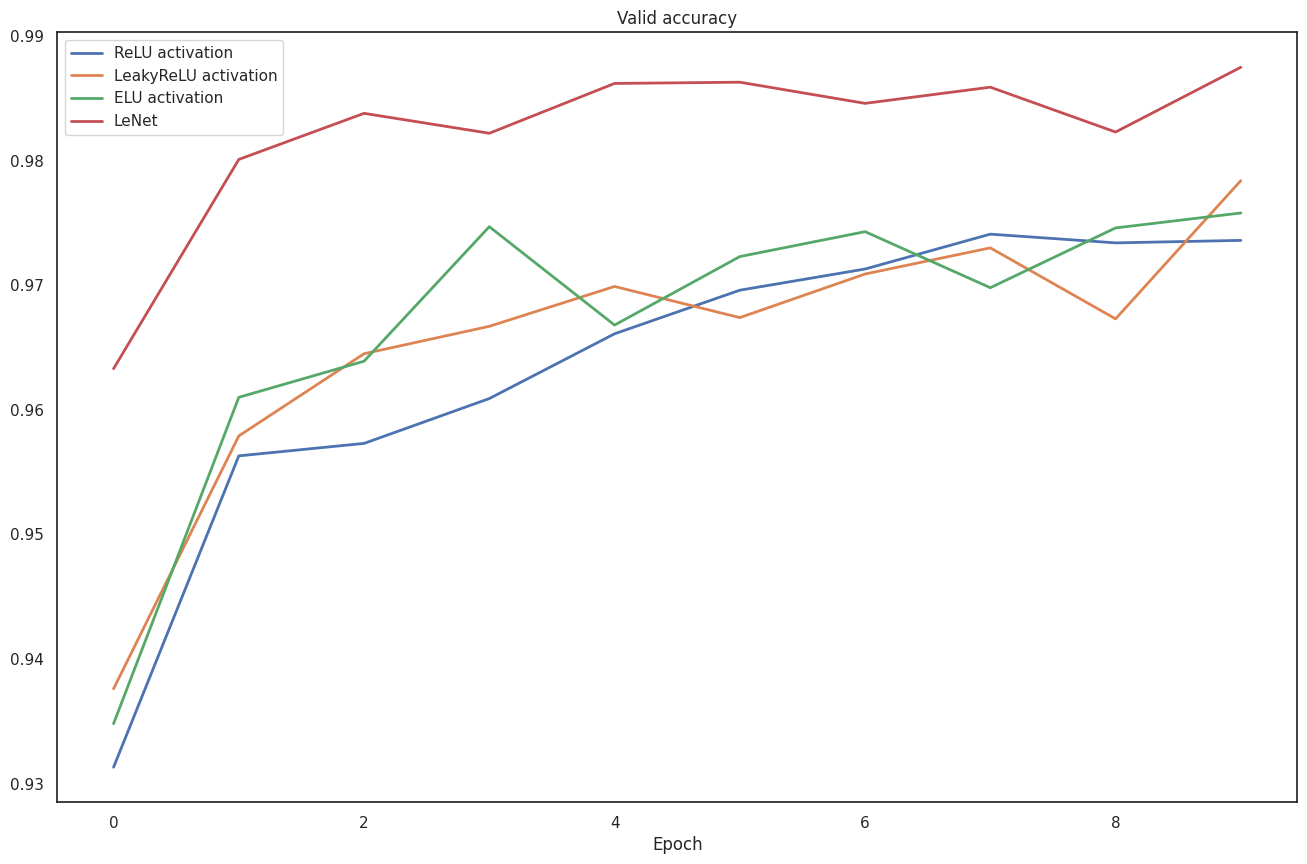

In [42]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.9875